In [12]:
from tifffile import imread
import os
from matplotlib import pyplot as plt
import json
from scipy.io import loadmat
import h5py
import numpy as np

In [13]:
pth_WSI_segmentations = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\ndpi\StarDist_1_12_24\json'
npdi_im_path = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\ndpi'
geojson_file = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\qupath\new_temp\geojson\H15_0277.geojson'

In [14]:
json_pth_list = [os.path.join(pth_WSI_segmentations,file) for file in os.listdir(pth_WSI_segmentations) if file.endswith(".json")]
print(json_pth_list)

['\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\BTC\\ndpi\\StarDist_1_12_24\\json\\H15_0277.json']


In [15]:
im_list = os.listdir(npdi_im_path)
im_list = [im for im in im_list if im.endswith('.ndpi')]

In [16]:
# read one image
ind = 0

HE_20x_WSI = imread(os.path.join(npdi_im_path, im_list[ind]))

In [17]:
# immune
crop_x = 33949
crop_y = 34343
tile_size = 512

# cancer
crop_x = 13587 - 300
crop_y = 18612 - 800
tile_size = 512*6

HE_20x_tile = HE_20x_WSI[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

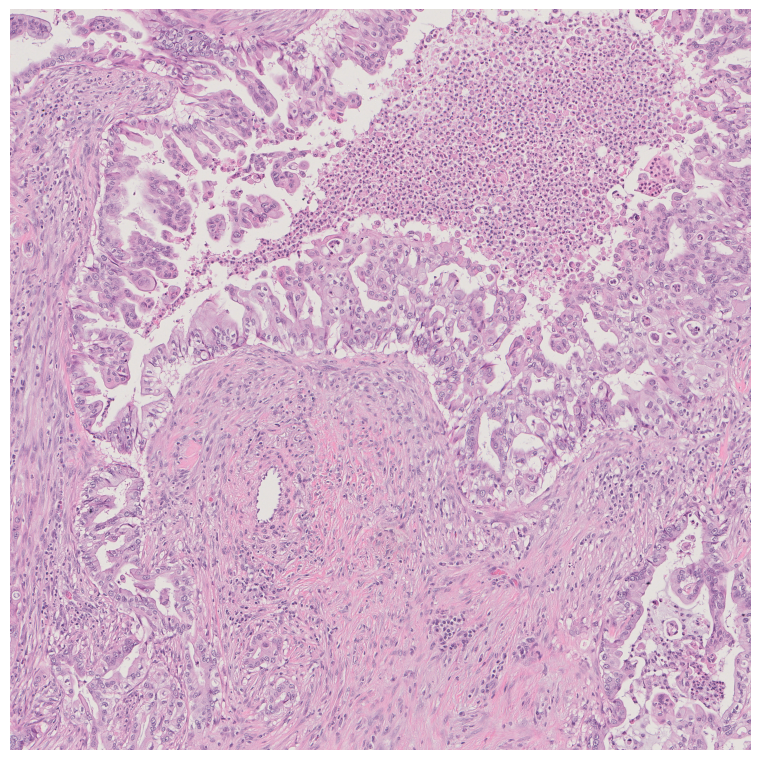

In [18]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()
    
show_tile(HE_20x_tile)

In [19]:
# https://stackoverflow.com/questions/71027729/finding-optimal-nearest-neighbour-pairs

# match closest pairs of coordinates in two sets of x,y coordinates

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csgraph

def colocalize_points(points_a: np.ndarray, points_b: np.ndarray, r: int):
    """ Find pairs that minimize global distance. Filters out anything outside radius `r` """

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(points_b)
    distances, b_indices = neigh.radius_neighbors(points_a, radius=r)

    # flatten and get indices for A. This will also drop points in A with no matches in range
    d_flat = np.hstack(distances) + 1
    b_flat = np.hstack(b_indices)
    a_flat = np.array([i for i, neighbors in enumerate(distances) for n in neighbors])

    # filter out A points that cannot be matched
    sm = csr_matrix((d_flat, (a_flat, b_flat)))
    a_matchable = csgraph.maximum_bipartite_matching(sm, perm_type='column')
    sm_filtered = sm[a_matchable != -1]

    # now run the distance minimizing matching
    row_match, col_match = csgraph.min_weight_full_bipartite_matching(sm_filtered)
    return row_match, col_match

In [20]:
geo_data = json.load(open(geojson_file))
print(geo_data.keys())

dict_keys(['type', 'features'])


In [21]:
centroids_ann = []

for i in range(len(geo_data['features'])):
    data = geo_data['features'][i]
    coords = data['geometry']['coordinates'][0]
    
    x_cent = 0
    y_cent = 0
    for pair in coords:
        x_cent += pair[1]
        y_cent += pair[0]
    x_cent /= len(coords)
    y_cent /= len(coords)
    
    # print(x_cent, y_cent)
    centroids_ann.append([x_cent, y_cent])

In [22]:
segmentation_data = json.load(open(json_pth_list[ind]))

centroids = [nuc['centroid'][0] for nuc in segmentation_data]
contours = [nuc['contour'] for nuc in segmentation_data]
print(len(centroids))
print(len(contours))

355861
355861


In [23]:
centroids_ann_np = np.array(centroids_ann)
centroids_total_np = np.array(centroids)

In [24]:
results = colocalize_points(centroids_ann_np, centroids_total_np, r=20)

In [25]:
centroids_annotated = [centroids_ann_np[i] for i in results[0]]
centroids_all = [centroids_total_np[i] for i in results[1]]

In [26]:
centroids_matched = [pair.tolist() for pair in centroids_all]

adj_centroids_matched = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids_matched]

adj_centroids = [[pair[0] - crop_y, pair[1] - crop_x] for pair in centroids]
centroids_in_tile_seg = [pair for pair in adj_centroids if 0 < crop_y < tile_size and 0 < crop_x < tile_size and pair not in adj_centroids_matched]

indices_matched = [adj_centroids.index(pair) for pair in adj_centroids if pair in adj_centroids_matched]

indices_not_matched = [adj_centroids.index(pair) for pair in adj_centroids if 0 < pair[1] < tile_size and 0 < pair[0] < tile_size and pair not in adj_centroids_matched]  # and within crop range

print(len(indices_matched))
print(len(indices_not_matched))

287
9341


In [27]:
def adjust_contours(contours_matched, x, y):

    contours_matched_adjusted = []
    for i in range(len(contours_matched)):
        contour = contours_matched[i][0]
        x_coords = contour[0]
        y_coords = contour[1]
        x_coords = [point-x for point in x_coords]
        y_coords = [point-y for point in y_coords]
        
        shape = list(zip(x_coords, y_coords))
        contours_matched_adjusted.append(shape)
    
    return contours_matched_adjusted

In [28]:
contours_matched = [contours[i] for i in indices_matched]
contours_not_matched = [contours[i] for i in indices_not_matched] 

contours_matched_adjusted = adjust_contours(contours_matched, crop_y, crop_x)
contours_not_matched_adjusted = adjust_contours(contours_not_matched, crop_y, crop_x)

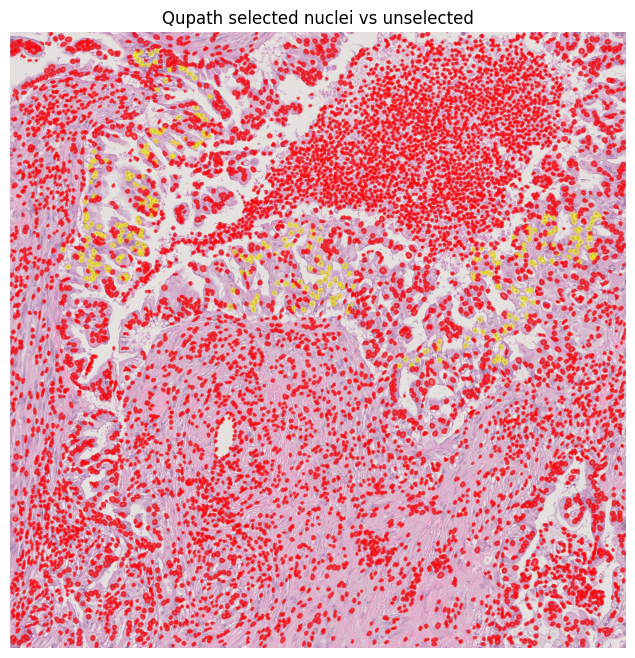

In [29]:
reversed_contours = [[(y, x) for x, y in polygon] for polygon in contours_matched_adjusted]

reversed_contours_negative = [[(y, x) for x, y in polygon] for polygon in contours_not_matched_adjusted]

fig, ax = plt.subplots(figsize=(16, 8))

# Plot the image
ax.imshow(HE_20x_tile)
ax.set_axis_off()

# Plot each reversed polygon on the same image
for polygon in reversed_contours:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'yellow'

    ax.plot(x_coords, y_coords, alpha=0.3, color=color)
    ax.fill(x_coords, y_coords, alpha=0.3, color=color)  # Fill the polygon
    
# Plot each reversed polygon on the same image
for polygon in reversed_contours_negative:
    x_coords, y_coords = zip(*polygon)
    x_coords = list(x_coords) + [x_coords[0]]  # Close the polygon
    y_coords = list(y_coords) + [y_coords[0]]  # Close the polygon

    color = 'red'
    
    skip = False
    for x in x_coords:
        if x < 0 or x > (tile_size - 1):
            skip = True
            break
    for y in y_coords:
        if y < 0 or y > (tile_size - 1):
            skip = True
            break
    
    if not skip:

        ax.plot(x_coords, y_coords, alpha=0.4, color=color)
        ax.fill(x_coords, y_coords, alpha=0.4, color=color)  # Fill the polygon

# Set labels and title for the plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Qupath selected nuclei vs unselected')

plt.show()

In [30]:
# trying to get intensity inside those pixels now:

len(contours_matched)

287

In [46]:
import cv2

In [32]:
np.max(np.array(HE_20x_tile, dtype=np.uint8))

255

In [61]:
print(len(contours))

355861


In [51]:
r_avg_list = []
g_avg_list = []
b_avg_list = []

for polygon in reversed_contours:
    contour_coordinates = np.array([[x, y] for x, y in polygon], dtype=np.float32)
    
    # Create a single-channel mask
    mask = np.zeros_like(HE_20x_tile[:, :, 0], dtype=np.uint8)
    
    # Draw contours on the single-channel mask
    cv2.drawContours(mask, [contour_coordinates.astype(int)], 0, (255), thickness=cv2.FILLED)
    
    
    
    r_masked = cv2.bitwise_and(HE_20x_tile[:, :, 0], HE_20x_tile[:, :, 0], mask=mask)
    g_masked = cv2.bitwise_and(HE_20x_tile[:, :, 1], HE_20x_tile[:, :, 1], mask=mask)
    b_masked = cv2.bitwise_and(HE_20x_tile[:, :, 2], HE_20x_tile[:, :, 2], mask=mask)
    
    num_pixels = np.count_nonzero(mask)
    
    r_avg = round(np.sum(r_masked)/num_pixels,2)
    g_avg = round(np.sum(g_masked)/num_pixels,2)
    b_avg = round(np.sum(b_masked)/num_pixels,2)
    
    r_avg_list.append(r_avg)
    g_avg_list.append(g_avg)
    b_avg_list.append(b_avg)

In [54]:
len(r_avg_list)

287

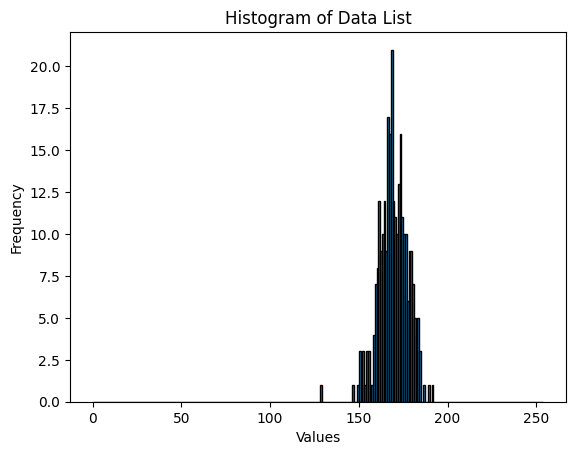

In [55]:
plt.hist(r_avg_list, bins=range(0, 255), edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('R Channel')

# Display the histogram
plt.show()

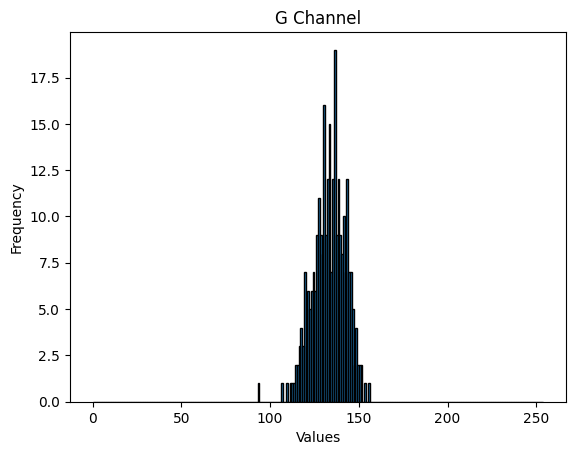

In [56]:
plt.hist(g_avg_list, bins=range(0, 255), edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('G Channel')

# Display the histogram
plt.show()

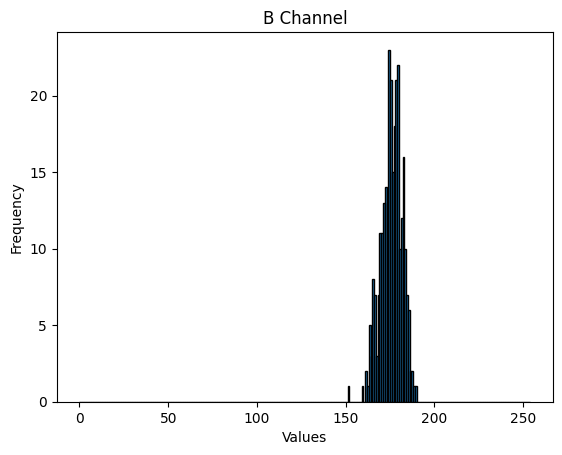

In [57]:
plt.hist(b_avg_list, bins=range(0, 255), edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('B Channel')

# Display the histogram
plt.show()

In [60]:
print(len(indices_matched))
print(len(r_avg_list))

287
287


Get df of features of nuc morphology

In [19]:
import pandas as pd
import cv2

In [20]:
# def json2df():
def cntarea(cnt):
    cnt = np.array(cnt).astype(np.float32)
    area = cv2.contourArea(cnt)
    return area

def cntperi(cnt):
    cnt = np.array(cnt).astype(np.float32)
    perimeter = cv2.arcLength(cnt,True)
    return perimeter

def cntMA(cnt):
    cnt = np.array(cnt).astype(np.float32)
    #Orientation, Aspect_ratio
    [(x,y),(MA,ma),orientation] = cv2.fitEllipse(cnt)
    return [np.max((MA,ma)),np.min((MA,ma)),orientation]

In [21]:
outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\json\features_pickle\test.pickle'
# print(outpth)

if not os.path.exists(outpth):
    data = segmentation_data

    centroids = []
    contours = []

    for entry in data:
        cent = entry['centroid'][0]
        centroids.append(cent)
        c = entry['contour'][0]
        contour = []
        for j in range(len(c[0])):
            point = [c[0][j], c[1][j]]
            contour.append(point)
        contours.append(contour)

    centroids = np.array(centroids)
    contours = np.array(contours)

    if len(centroids) == 0:
        print(f'Skipping')
    else:

        areas = []
        perimeters = []
        circularities = []
        aspect_ratios = []
        image_ids = []
        classes = []

        compactness_a, eccentricity_a, euler_number_a, extent_a, form_factor_a, maximum_radius_a, mean_radius_a, median_radius_a, minor_axis_length_a, orientation_degrees_a = [], [], [], [], [], [], [], [], [], []

        for j, centroid in enumerate(centroids):
            contour = contours[j]
            area = cntarea(contour)
            perimeter = cntperi(contour)
            circularity = 4 * np.pi * area / perimeter ** 2
            MA = cntMA(contour)
            [MA, ma, orientation] = MA
            aspect_ratio = MA / ma
            center_x = centroid[0]
            center_y = centroid[1]

            # Additional features
            compactness = perimeter ** 2 / area
            eccentricity = np.sqrt(1 - (ma / MA) ** 2)
            extent = area / (MA * ma)
            form_factor = (perimeter ** 2) / (4 * np.pi * area)
            major_axis_length = MA
            maximum_radius = np.max(np.linalg.norm(contour - centroid, axis=1))
            mean_radius = np.mean(np.linalg.norm(contour - centroid, axis=1))
            median_radius = np.median(np.linalg.norm(contour - centroid, axis=1))
            minor_axis_length = ma
            orientation_degrees = np.degrees(orientation)

            areas.append(area)
            perimeters.append(perimeter)
            circularities.append(circularity)
            aspect_ratios.append(aspect_ratio)

            # additional features
            compactness_a.append(compactness)
            eccentricity_a.append(eccentricity)
            extent_a.append(extent)
            form_factor_a.append(form_factor)
            maximum_radius_a.append(maximum_radius)
            mean_radius_a.append(mean_radius)
            median_radius_a.append(median_radius)
            minor_axis_length_a.append(minor_axis_length)
            orientation_degrees_a.append(orientation_degrees)

        dat = {
            'Centroid_x': centroids[:,0],
            'Centroid_y': centroids[:,1],
            'Area': areas,
            'Perimeter': perimeters,
            'Circularity': circularities,
            'Aspect Ratio': aspect_ratios,
            'compactness' : compactness_a,
            'eccentricity' : eccentricity_a,
            'extent' : extent_a,
            'form_factor' : form_factor_a,
            'maximum_radius' : maximum_radius_a,
            'mean_radius' : mean_radius_a,
            'median_radius' : median_radius_a,
            'minor_axis_length' : minor_axis_length_a,
            'orientation_degrees' : orientation_degrees_a,
        }

        df = pd.DataFrame(dat)

        # df.to_pickle(outpth)

KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:
len(df)

In [ ]:
features_df = df[[
            'Area',
            'Perimeter',
            #'Circularity',
            'Aspect Ratio',
            'compactness',
            #'eccentricity',
            'extent',
            'form_factor',
            'maximum_radius'
            #'mean_radius',
            #'median_radius',
            #'minor_axis_length'
            #'orientation_degrees'
]]
features_df.head()

In [ ]:
# I want to separate df by nuc that I annotated vs nuc that I didn't annotate:
features_df_matched = features_df.loc[df.index.isin(indices_matched)]
features_df_others = features_df.loc[~df.index.isin(indices_matched)]

print(len(features_df_matched))
print(len(features_df_others))

In [ ]:
# now I'll just add them to the end of this subsampled df so that I still know their indicies
sample_features_df = features_df_others.sample(frac=0.2)
len_sample = len(sample_features_df)
print(len_sample)

sample_features_df

# Get the remaining 80% of the data
remaining_features_df = features_df_others.drop(sample_features_df.index)

In [ ]:
combined_df = pd.concat([sample_features_df, features_df_matched], axis=0)
print(len(combined_df))

In [ ]:
sample_features_df.head()

In [ ]:
combined_df.head()

In [ ]:
indices = range(len_sample,len(combined_df))
print(indices)

In [ ]:
import pandas as pd

# Assuming 'combined_df' is a DataFrame containing your data

# Get the list of features from combined_df
features = combined_df.columns

quantiles_5_to_95 = combined_df[features].iloc[indices].quantile([0.05, 0.95])

# Print or use the quantiles as needed
print("10% to 90% Quantiles:")
print(quantiles_5_to_95)


In [ ]:
# Get the list of features from combined_df
features = combined_df.columns

# Set up subplots
num_features = len(features)
num_cols = 3  # You can adjust the number of columns based on your preference
num_rows = (num_features + num_cols - 1) // num_cols

features = combined_df.columns

# Set up subplots
num_features = len(features)
num_cols = 3  # You can adjust the number of columns based on your preference
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate through each feature and create a scatter plot
for i, feature in enumerate(features):
    ax = axes[i // num_cols, i % num_cols]
    
    # Define colors and sizes based on indices
    colors = ['red' if j in indices else 'blue' for j in range(len(combined_df))]
    sizes = [25 if j in indices else 1 for j in range(len(combined_df))]
    
    # Plot the scatter plot for the current feature
    scatter = ax.scatter(combined_df[feature], combined_df[feature], c=colors, s=sizes)
    ax.set_title(f'Scatter plot for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel(feature)
    
    # Add legend for clarity
    if i == 0:
        ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Specified Indices')],
                  loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
y_train = [1 if i in indices else 0 for i in range(len(combined_df))]

In [ ]:
import umap  # https://umap.scikit-tda.org/transform.html
import matplotlib.pyplot as plt

trans = umap.UMAP(n_components=2, random_state=42).fit(combined_df)

In [ ]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train)
plt.title('Embedding of the training set by UMAP', fontsize=12);

In [ ]:
transformed_rest_df = trans.transform(remaining_features_df)

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering with 3 clusters
kmeans_model = KMeans(n_clusters=5)
clusters = kmeans_model.fit_predict(trans.embedding_)

In [ ]:
# Define colors and sizes based on cluster labels
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' for cluster in clusters]
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' if cluster == 2 else 'yellow' if cluster == 3 else 'orange' for cluster in clusters]
sizes = [25 for _ in range(len(combined_df))]  # Adjust the size if needed

# Plot the transformed features using UMAP with different colors and sizes for clusters
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot with K-means Clustering')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 0'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Cluster 2'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Cluster 3'), 
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Cluster 4')],
           loc='upper right')

plt.show()

In [ ]:
predictions = kmeans_model.predict(transformed_rest_df)

In [ ]:
print(f'0: {sum(predictions == 0)}')
print(f'1: {sum(predictions == 1)}')
print(f'2: {sum(predictions == 2)}')
print(f'2: {sum(predictions == 3)}')
print(f'2: {sum(predictions == 4)}')

In [ ]:
indices_cluster_0 = (predictions == 0).nonzero()[0]
print(len(indices_cluster_0))

In [ ]:
predictions[:10]

In [ ]:
indices_cluster_0[:5]

In [ ]:
len(predictions)

In [ ]:
contours_new = [i for i in range(len(contours)) if i not in sample_features_df.index]
print(len(contours_new))

contours_new = contours[contours_new]

In [ ]:
contours_new[:5]

In [ ]:
good_contours = contours_new[indices_cluster_0]

In [ ]:
GEOdata = []

for contour in good_contours:
    contour = [[coord for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [ ]:
import geojson

outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\test_immune_cells\cancer.geojson'

with open(outpth,'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished')

In [ ]:
import umap  # https://umap.scikit-tda.org/transform.html
import matplotlib.pyplot as plt

# Create UMAP model with 2 components
umap_model = umap.UMAP(n_components=2)
transformed_features_umap = umap_model.fit_transform(combined_df)

# Define colors and sizes based on indices
colors = ['red' if i in indices else 'blue' for i in range(len(combined_df))]
sizes = [25 if i in indices else 1 for i in range(len(combined_df))]

# Plot the transformed features using UMAP with different colors and sizes for specified indices
scatter = plt.scatter(transformed_features_umap[:, 0], transformed_features_umap[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Specified Indices')],
           loc='upper right')

plt.show()



In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering with 3 clusters
kmeans_model = KMeans(n_clusters=3)
clusters = kmeans_model.fit_predict(transformed_features_umap)

# Define colors and sizes based on cluster labels
colors = ['red' if cluster == 0 else 'blue' if cluster == 1 else 'green' for cluster in clusters]
sizes = [25 for _ in range(len(combined_df))]  # Adjust the size if needed

# Plot the transformed features using UMAP with different colors and sizes for clusters
scatter = plt.scatter(transformed_features_umap[:, 0], transformed_features_umap[:, 1], c=colors, s=sizes)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot with K-means Clustering')

# Add a legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 0'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Cluster 2')],
           loc='upper right')

plt.show()

In [ ]:
cluster_0_indices = [index for index, cluster_label in enumerate(clusters) if cluster_label == 0]

# Display the indices of Cluster 0
print("Indices of Cluster 0:", len(cluster_0_indices))

In [ ]:
# trying brute force approach

q_Area = [64.844785,127.798974]
q_Perimeter = [31.110758,42.056153]
q_Aspect_Ratio = [1.064367,1.577907]
q_compactness = [13.068521,15.302649]
q_extent = [0.757991,0.777657]
q_form_factor = [1.039960,1.217746]
q_maximum_radius = [5.620915,8.921496]

mask_Area = (features_df['Area'] >= q_Area[0]) & (features_df['Area'] <= q_Area[1])
mask_Perimeter = (features_df['Perimeter'] >= q_Perimeter[0]) & (features_df['Perimeter'] <= q_Perimeter[1])
mask_Aspect_Ratio = (features_df['Aspect Ratio'] >= q_Aspect_Ratio[0]) & (features_df['Aspect Ratio'] <= q_Aspect_Ratio[1])
mask_compactness = (features_df['compactness'] >= q_compactness[0]) & (features_df['compactness'] <= q_compactness[1])
mask_extent = (features_df['extent'] >= q_extent[0]) & (features_df['extent'] <= q_extent[1])
mask_form_factor = (features_df['form_factor'] >= q_form_factor[0]) & (features_df['form_factor'] <= q_form_factor[1])
mask_maximum_radius = (features_df['maximum_radius'] >= q_maximum_radius[0]) & (features_df['maximum_radius'] <= q_maximum_radius[1])

# Apply the masks to filter the DataFrame
subset_df = features_df[mask_Area & mask_Perimeter & mask_Aspect_Ratio & mask_compactness & mask_extent & mask_form_factor & mask_maximum_radius]

len(subset_df)

In [ ]:
good_indices = subset_df.index
good_indices[-5:]

In [ ]:
good_contours = contours[good_indices]

In [ ]:
GEOdata = []

for contour in good_contours:
    contour = [[coord for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)

In [ ]:
import geojson

outpth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\BTC\test_immune_cells\test.geojson'

with open(outpth,'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished')